In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict
import random
from numpy.random import choice
random.seed(10)
np.random.seed(10)
import math
%matplotlib inline

### Load Data

In [2]:
demands = pd.read_excel(open('demands22.xlsx', 'rb'))
assuta_items = pd.read_excel("Assuta_items.xlsx")
refresh = pd.read_excel("refresh.xlsx")
initial_inventory = pd.read_excel("Initial_inventory.xls")
daily_demands_22 = pd.read_excel("daily demands 22.xlsx")
volumes = pd.read_excel("volume.xlsx")

### Pre Processing

In [4]:
# fill nulls, rename, merge, slicing

demands.fillna(0,inplace=True)
demands.rename(columns = {f'{demands.columns[0]}':'SKU_ID'}, inplace = True)

assuta_items = pd.DataFrame(assuta_items.iloc[:,0])

refresh.fillna(0,inplace=True)

initial_inventory = initial_inventory.loc[:,['SKU','Total Qty']]
initial_inventory.rename(columns = {f'{initial_inventory.columns[0]}':'SKU_ID',f'{initial_inventory.columns[1]}':'Total Qty'}, inplace = True)

daily_demands_22.rename(columns = {f'{daily_demands_22.columns[0]}':'SKU_ID'}, inplace = True)
daily_demands_22.fillna(0,inplace=True)

volumes = volumes.iloc[:,:2]
volumes.rename(columns = {f'{volumes.columns[1]}':'volume'}, inplace = True)

In [5]:
# Remove assuta items from the dataframe
demands = demands[~demands["SKU_ID"].isin(assuta_items["SKU_ID"])]

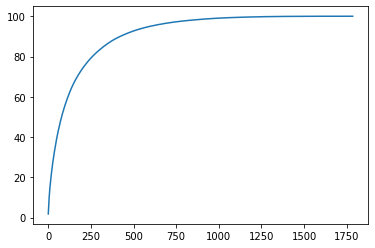

Group A includes 259 items


In [7]:
# Group A - 80% of the total demand
demands['sum_demands'] = np.sum(demands, axis=1)
demands_sum = demands.iloc[:,[0,-1]]
demands.drop(['sum_demands'], axis=1, inplace=True)
demands_sum.sort_values(by=['sum_demands'], ascending=False, inplace=True)

demands_sum['cumsum'] = demands_sum['sum_demands'].cumsum()
demands_sum['cumsum_perc'] = 100 * demands_sum['cumsum'] / demands_sum['sum_demands'].sum()

# fig = plt.figure(dpi=60, figsize=(10, 7))
plt.plot(np.arange(len(demands_sum['cumsum_perc'])),demands_sum['cumsum_perc'])
# plt.xlabel = 'Longitude'
# plt.ylabel = 'Latitude'
# plt.title('xlabels() function')
plt.show()
demands_sum['Up_To'] = demands_sum['cumsum_perc'] <= 80
good_sku_ids = demands_sum[demands_sum['Up_To']]
a_list_sku_ids = good_sku_ids['SKU_ID']
print(f'Group A includes {len(list(a_list_sku_ids))} items')

In [8]:
# Leave the SKU id's demands of group A
demands = demands[demands["SKU_ID"].isin(list(a_list_sku_ids))]

In [11]:
# Intersection of demands with all files
demands = demands[demands['SKU_ID'].isin(initial_inventory["SKU_ID"])]
demands = demands[demands['SKU_ID'].isin(daily_demands_22["SKU_ID"])]
demands = demands[demands['SKU_ID'].isin(refresh["SKU_ID"])]
demands = demands[demands['SKU_ID'].isin(volumes["SKU_ID"])]

In [13]:
# Make 3 lists - less (r<9.5), good (9.5<r>10.5), more (r>10.5) while r is the number of refreshes per month
refresh['mean'] = np.mean(refresh.iloc[:,1:].to_numpy(),axis=1)
sku_ids_0to95 = list(refresh[(refresh['mean']>=0)&(refresh['mean']<9.5)]['SKU_ID'])
sku_ids_95to105 = list(refresh[(refresh['mean']>=9.5)&(refresh['mean']<=10.5)]['SKU_ID'])
sku_ids_over105 = list(refresh[refresh['mean']>10.5]['SKU_ID'])

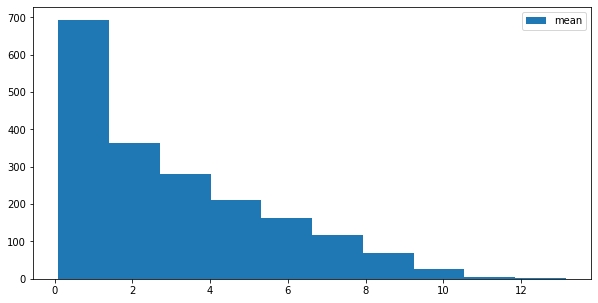

In [14]:
hist = refresh['mean'].hist(bins=10,grid=False,figsize=[10,5],legend=True)

In [15]:
lst1 = list(demands['SKU_ID']) # create a list of our SKU IDs
lst2 = sku_ids_0to95 + sku_ids_over105 # create a list of SKU IDs with an unsatisfactory amount of refreshes
relevant_sku_ids = list(set(lst1) & set(lst2)) # sku_ids of products that are not good (less or more)
print(f'The number of relevant sku_ids is: {len(relevant_sku_ids)}')

The number of relevant sku_ids is: 234


In [16]:
demands = demands[demands['SKU_ID'].isin(relevant_sku_ids)]
initial_inventory = initial_inventory[initial_inventory['SKU_ID'].isin(relevant_sku_ids)]
daily_demands_22 = daily_demands_22[daily_demands_22['SKU_ID'].isin(relevant_sku_ids)]
refresh = refresh[refresh['SKU_ID'].isin(relevant_sku_ids)]
volumes = volumes[volumes['SKU_ID'].isin(relevant_sku_ids)]

In [17]:
demands

,SKU_ID,1,2,3,4,5,6
3,35383015,4099,3771,4174,3454,4056,3877
7,0FK30730,1425,0,8288,2779,3241,3321
9,0LK00120,10234,9854,9152,10049,3299,0
13,2AK01910,2187,2076,2629,1473,1386,1213
14,2AK04010,1285,902,1393,1506,1588,1456
...,...,...,...,...,...,...,...
2568,RB001342,17955,9652,8072,7074,7615,8100
2569,RB001359,3755,2358,1650,1810,171,0
2570,RB001597,4233,4667,1285,1050,1741,1796
2571,RB001603,11951,6000,5203,4497,4697,4704


### Min Max

In [95]:
# get the demands for the last year and the min,max values
# return dictionary when the key is tuple of (sku_id,quarter number) and ......
# the value is tuple of (min,max) like - {('FC038348', 1): (27, 54),('FC038348', 2): (296, 592),.....}
def MinMax(demands,min,max):
    copy = demands.copy()
    columns = ['SKU_ID']
    for i in range(2):
        copy['Min'+str(i+1)] = (copy.iloc[:,i*3+1:i*3+4].mean(axis=1) / 22) * min
        copy['Max'+str(i+1)] = (copy.iloc[:,i*3+1:i*3+4].mean(axis=1) / 22) * max
        columns += ['Min'+str(i+1),'Max'+str(i+1)]
    copy = copy.loc[:,columns]
    dic = defaultdict(tuple)
    for index, row in copy.iterrows():
        for i in range(1,3):
            row = list(row)
            dic[(row[0],i)] = (row[2*i-1],row[2*i])
    return dic

### Simulation

In [96]:
# transfer 'daily_demands_22' into a dictionary structure
daily_demands_22_dic = defaultdict(list)
for index, row in daily_demands_22.iterrows():
    row = list(row)
    daily_demands_22_dic[row[0]] = row[1:]

In [97]:
# transfer 'initial_inventory' into a dictionary structure
initial_inventory_dic = defaultdict(list)
for index, row in initial_inventory.iterrows():
    row = list(row)
    initial_inventory_dic[row[0]] = row[1]

In [98]:
# transfer 'volumes' into a dictionary structure
volumes_dic = defaultdict(list)
for index, row in volumes.iterrows():
    row = list(row)
    volumes_dic[row[0]] = row[1]

In [99]:
# calculate how many units can be stored in each type of 'arkalit
def calc_capacity_per_arkalit(daily_demands_22_dic,volumes_dic,high_volume, low_volume):
    dic = defaultdict(dict)
    items_sku_ids = list(daily_demands_22_dic.keys())
    for item in items_sku_ids:
        cur_vol = volumes_dic[item]
        dic[item] = {'low_half':int((low_volume/2)/cur_vol), 'low_full':int(low_volume/cur_vol), 'high_half':int((high_volume/2)/cur_vol), 'high_full':int(high_volume/cur_vol)}
    return dic
capacity_per_arkalit = calc_capacity_per_arkalit(daily_demands_22_dic,volumes_dic,30000, 15000)

In [101]:
# loading 
def loading (sku_id, quantity, arkaliot, inventory_dic):
    global count_no_space
    global count_refresh
    effective_options = defaultdict(int) # initialize a new dictionary
    flag = False
    for (arkalit_type, num_of_free_arkaliot) in arkaliot.items(): # for every type of arkalit and its number of free units
        capacity_of_item_arkalit = capacity_per_arkalit[sku_id][arkalit_type] # how many units of the items can be stored in one arkalit of the checked type
        num_of_full_arkaliot = int(math.ceil(inventory_dic[sku_id][arkalit_type] / capacity_of_item_arkalit)) # how many arkaliot of this type are in use for the item
        total_arkaliot = num_of_free_arkaliot + num_of_full_arkaliot # total number of arkaliot can be used for this sku_id
        total_units = total_arkaliot * capacity_of_item_arkalit # number of item's units we can store within the arkaliot in use for it
        total_units_possible = total_units - inventory_dic[sku_id][arkalit_type] # number of units we can add within the free space in the arkaliot in use for the item
        if total_units_possible > 0: # if there is indeed free space for extra items within the arkaliot in use
            effective_options[arkalit_type] = total_units_possible # add the type of arkalit and num of units we can add to the dict
    while quantity > 0: # while there is a quantity of the item needed to be stored in the OSR
        if not effective_options: # if there is no free space in any of the arkaliot used by this item
            count_no_space += 1
            break
        else: # if there is any free space in any of the arkaliot used by this item
            flag = True
            arkalit_type = choice(list(effective_options.keys())) # ramdomly choose an arkalit type from the relevant options
            possible_loading = effective_options[arkalit_type] # number of units we can add to the chosen arkalit type
            if possible_loading > quantity: # if we can store all the units we need to this arkalit type + still have some free space
                loading = quantity # store all the needed quantity
                quantity = 0 
                effective_options[arkalit_type] -= loading # reduce the units space we used from the dict
            else: # if we can store less than what we need within this arkalit type or exactly the amount we need 
                loading = possible_loading # store everything we can
                quantity -= possible_loading # reduce the stored amount from the quantity needed to be stored
                del effective_options[arkalit_type] # remove the arkalit type from the possible options

            last_inventory = inventory_dic[sku_id][arkalit_type]
            new_inventory = last_inventory + loading # update the inventory dict with the amount we loaded into the OSR
            capacity = capacity_per_arkalit[sku_id][arkalit_type]
            added_arkaliot = int(math.ceil(new_inventory/capacity) - math.ceil(last_inventory/capacity)) # how many new arkaliot we needed for this storing  
                
            inventory_dic[sku_id][arkalit_type] = int(new_inventory)   
            arkaliot[arkalit_type] -= added_arkaliot # reduce the arkaliot we used from the dict of free arkaliot 
    if flag:
        count_refresh += 1

In [102]:
def pull_out(sku_id,quantity,arkaliot,inventory_dic):
    # effective_options = [k for (k, v) in inventory_dic[sku_id].items() if v > 0]
    global count_no_inventory
    global sum_no_inventory
    while quantity > 0:
        effective_options = [k for (k, v) in inventory_dic[sku_id].items() if v > 0] # all options for arkalit types containing the item
        if not effective_options: # if there are no units of the item stored 
            count_no_inventory += 1
            sum_no_inventory += quantity
            break
        # happens only if there are any effective options: 
        arkalit_type = choice(effective_options) # choose a random type of arkalit type 
        inventory = inventory_dic[sku_id][arkalit_type]
        capacity = capacity_per_arkalit[sku_id][arkalit_type]
        if inventory % capacity == 0: # if all of the arakliot holding the item are full
            pull_out = capacity # pull out the amount of units in a full arkalit
        else: # if there is at least 1 araklit holding the item that is not full
            pull_out = int(inventory % capacity) # take all the items from the arkalit that is not full
        if pull_out > quantity: # if the amount of units is larger than what is needed
            pull_out = quantity # take only the amount we actually need and not more
            quantity = 0 
        else: # if the amount of units is not larger than what is needed
            quantity -= pull_out # reduce the amount of units we pulled from the required quantity
            arkaliot[arkalit_type] += 1 # update arkaliot dict with a free arkalit of the type we pulled from 
        inventory_dic[sku_id][arkalit_type] -= int(pull_out) # reduce the amount of units pulled from the inventory

In [103]:
# calc initial inventory
def calc_initial_inventory(daily_demands_22_dic, initial_inventory, capacity_per_arkalit, arkaliot):
    inventory_dic = defaultdict(dict)
    items_sku_ids = list(daily_demands_22_dic.keys())
    options = ['low_half','low_full','high_half','high_full']
    for item in items_sku_ids:
        inventory_dic[item] = {i:0 for i in options}
    for item in items_sku_ids:
        # capacity = capacity_per_arkalit[item][arkalit_type]
        inventory = initial_inventory[item]
        loading (item, inventory, arkaliot, inventory_dic)
    return inventory_dic

# arkaliot = {'low_half':2*int(1383) ,'low_full':int(1476), 'high_half':2*int(3251), 'high_full':int(7247)}
# calc_initial_inventory = initial_inventory(daily_demands_22_dic, initial_inventory_dic, capacity_per_arkalit,arkaliot)

In [104]:
# calc 'others' volume
demands_others = pd.read_excel(open('demands22.xlsx', 'rb'))
volumes_others = pd.read_excel("volume.xlsx")
assuta_items = pd.read_excel("Assuta_items.xlsx")

demands_others.fillna(0,inplace = True)
demands_others.rename(columns = {f'{demands_others.columns[0]}':'SKU_ID'}, inplace = True)
volumes_others = volumes_others.iloc[:,:2]
volumes_others.rename(columns = {f'{volumes_others.columns[1]}':'volume'}, inplace = True) # keep all items which don't belong to group A or Assuta
assuta_items = pd.DataFrame(assuta_items.iloc[:,0])

demands_others = demands_others[~demands_others.SKU_ID.isin(list(demands.SKU_ID))]
demands_others = demands_others[~demands_others["SKU_ID"].isin(assuta_items["SKU_ID"])]

demands_others['Max'] = (demands_others.mean(axis=1) / 22) * 6
df = pd.merge(demands_others, volumes_others, on='SKU_ID', how='left')
df = df[['SKU_ID','Max','volume']]
low_half_others, low_full_others,high_full_others = 0,0,0
for index, row in df.iterrows():
    if row['volume'] > 15000:
        high_full_others += math.ceil(row['Max']/math.floor(30000 / row['volume']))
    elif row['volume'] > 7500:
        low_full_others += math.ceil(row['Max']/math.floor(15000 / row['volume']))
    elif row['volume'] > 0:
        arkalit_type = choice(['full','half'])
        if arkalit_type == 'full':
            low_full_others += math.ceil(row['Max']/math.floor(15000 / row['volume']))
            # low_full_others += int(row['Max']/max(1,math.floor(15000 / row['volume'])))
        else:
            low_half_others += math.ceil(row['Max']/math.floor(7500 / row['volume']))
            # low_half_others += int(row['Max']/max(1,math.floor(7500 / row['volume'])))

In [105]:
low_full_others,low_half_others,high_full_others

(1860, 3675, 0)

In [106]:
# # remove the 'others' volume (arkaliot)
# def remove_other(arkaliot,low_full_others,low_half_others):
#     if arkaliot['low_half'] < low_half_others:
#         low_full_others += int(math.ceil(0.5 * (low_half_others - arkaliot['low_half'])))
#         arkaliot['low_half'] = 0
#     else:
#         arkaliot['low_half'] -= low_half_others
#     if arkaliot['low_full'] < low_full_others:
#         if arkaliot['high_half'] >= low_full_others - arkaliot['low_full']:
#             arkaliot['high_half'] -= low_full_others - arkaliot['low_full'] # reduce the rest from high half
#         else:
#             if arkaliot['high_full'] >= arkaliot['high_half'] - (low_full_others - arkaliot['low_full']):
#                 arkaliot['high_full'] -= int(math.ceil(0.5 * (low_half_others - arkaliot['low_half'])))
#         arkaliot['low_full'] = 0 # reduce all low full because we used them for 'others'

#         if arkaliot['high_half'] < 0: # if we used more high half than available
#             print(arkaliot['high_half']) 
#             arkaliot['high_full'] -= int(math.ceil(0.5 * - arkaliot['high_half'])) # use high full arkaliot instead of the missing ones
#             arkaliot['high_half'] = 0
#             if arkaliot['high_full'] < 0:
#                 print('There are no arkaliots left')
#     else:
#         arkaliot['low_full'] -= low_full_others


# # arkaliot = {'low_half':10 ,'low_full':15, 'high_half':1, 'high_full':7}
# # low_half_others,low_full_others = (9,18)
# # remove_other(arkaliot,low_full_others,low_half_others)

# # proportion = 0.98 # the proportion of the OSR that can be uesd
# # arkaliot = {'low_half':2*int(1383 * proportion) ,'low_full':int(1476 * proportion), 'high_half':2*int(3251 * proportion), 'high_full':int(7247 * proportion)}
# # remove_other(arkaliot,low_full_others,low_half_others)

In [107]:
# remove the 'others' volume (arkaliot)
def remove_other(arkaliot,low_full_others,low_half_others,high_full_others):
    arkaliot['low_half'] -= low_half_others
    if arkaliot['low_half'] < 0:
       low_full_others += int(math.ceil(0.5 * -arkaliot['low_half']))
       arkaliot['low_half'] = 0
    arkaliot['low_full'] -= low_full_others
    if arkaliot['low_full'] < 0:
        arkaliot['high_half'] -= -arkaliot['low_full']
        arkaliot['low_full'] = 0
        if arkaliot['high_half'] < 0: # if we used more high half than available
            arkaliot['high_full'] -= int(math.ceil(0.5 * -arkaliot['high_half'])) # use high full arkaliot instead of the missing ones
            arkaliot['high_half'] = 0
            if arkaliot['high_full'] < 0:
                arkaliot['high_full'] = 0
                print('There are no arkaliots left')
    arkaliot['high_full'] -= high_full_others
        
# arkaliot = {'low_half':5 ,'low_full':5, 'high_half':1, 'high_full':7}
# low_half_others,low_full_others = (2,6)
# high_full_others = 4
# remove_other(arkaliot,low_full_others,low_half_others,high_full_others)
# arkaliot

# proportion = 0.98 # the proportion of the OSR that can be uesd
# arkaliot = {'low_half':2*int(1383 * proportion) ,'low_full':int(1476 * proportion), 'high_half':2*int(3251 * proportion), 'high_full':int(7247 * proportion)}
# remove_other(arkaliot,low_full_others,low_half_others)

In [108]:
# # check if there is a free space in a specific type of arkalit
# def check_place(sku_id,type_of_arkalit, number_of_units):
#     capacity = 6
#     # capacity = capacity_per_arkalit[sku_id][type_of_arkalit]
#     return (int(number_of_units/capacity),number_of_units%capacity)

In [109]:
# global count_no_space
# global count_no_inventory
# global sum_no_inventory
# global count_refresh
# count_no_space = 0 # counter of times we have exceeded the storage capacity
# count_no_inventory = 0 # counter of times we dont have enough inventory to pull out
# sum_no_inventory = 0 # how many units in total we couldnt pull out
# count_refresh = 0 # counter of refreshes

# proportion = 0.98 # the proportion of the OSR that can be uesd
# arkaliot = {'low_half':2*int(1383 * proportion) ,'low_full':int(1476 * proportion), 'high_half':2*int(3251 * proportion), 'high_full':int(7247 * proportion)}
# remove_other(arkaliot,low_full_others,low_half_others,high_full_others)

# inventory_dic = calc_initial_inventory(daily_demands_22_dic, initial_inventory_dic, capacity_per_arkalit,arkaliot)

# c=0
# for i,j in inventory_dic.items():
#     for k in j.values():
#         if isinstance(k, float):
#             c+=1
# c

In [110]:
# inventory_dic

In [111]:
# capacity_per_arkalit['2CK13811']

In [112]:
# inventory_dic['2CK13811']

In [113]:
# arkaliot

In [114]:
# loading ('2CK13811',10,arkaliot,inventory_dic)

In [115]:
# inventory_dic

In [116]:
# arkaliot

In [117]:
# pull_out('2CK13811',171,arkaliot,inventory_dic)
# inventory_dic

In [118]:
# arkaliot

In [119]:
def simulation (daily_demands:dict,initial_inventory:dict,volumes:dict,minmax:dict,capacity_per_arkalit:dict):
    
    days = len(daily_demands[list(daily_demands.keys())[0]]) # number of days we will run through
    items_sku_ids = list(daily_demands.keys()) # list of sku ids
    refresf_dic = {item:False for item in items_sku_ids} # initialize a dictionary with 'False' value for each sku id
    
    current_day = 0 # holds the day number in each iteration 
    current_quarter = 1 # holds the quarter number in each iteration
    
    global count_no_space
    global count_no_inventory
    global sum_no_inventory
    global count_refresh
    count_no_space = 0 # counter of times we have exceeded the storage capacity
    count_no_inventory = 0 # counter of times we dont have enough inventory to pull out
    sum_no_inventory = 0 # how many units in total we couldnt pull out
    count_refresh = 0 # counter of refreshes
    
    proportion = 0.97 # the proportion of the OSR that can be used
    arkaliot = {'low_half':2*int(1383 * proportion) ,'low_full':int(1476 * proportion), 'high_half':2*int(3251 * proportion), 'high_full':int(7247 * proportion)}
    remove_other(arkaliot,low_full_others,low_half_others,high_full_others)
    
    inventory_dic = calc_initial_inventory(daily_demands, initial_inventory, capacity_per_arkalit,arkaliot)
    
    for day in range(days): # go through all days
        total_volume = 0 # sum up the volumes per day
        for item in items_sku_ids: # go through all items
            if refresf_dic[item]: # check if refresh is required for the specific item
                curr_inventory = sum(inventory_dic[item].values()) # current inventory
                new_inventory = minmax[(item,current_quarter)][1] # refresh to maximum
                loading(item,new_inventory-curr_inventory,arkaliot,inventory_dic)
                refresf_dic[item] = False # after refreshing, change again the refresh requirement into 'False' 
            # item_volume = initial_inventory[item] * volumes[item] # calc the item volume based on the existing inventory and the volume per unit
            # total_volume += item_volume # add the item volume to the total volume
            
            pull_out(item,daily_demands[item][day],arkaliot,inventory_dic) # update the inventory

            if sum(inventory_dic[item].values()) < minmax[(item,current_quarter)][0]: # check if inventory is less than the minimum
                refresf_dic[item] = True # change  the refresh requirement into 'True' 
                # count_refresh += 1 # add 1 to the refreshes counter

        current_day += 1 # update the day counter
        if current_day <= 90: current_quarter = 1 # change the quarter according to the day 
        else: current_quarter = 2 # change the quarter according to the day
    return count_refresh,count_no_space,count_no_inventory,int(sum_no_inventory)

In [120]:
# daily_demands_22_dic_copy = daily_demands_22_dic.copy()
# initial_inventory_dic_copy = initial_inventory_dic.copy()
# volumes_dic_copy = volumes_dic.copy()
# minmax = MinMax(demands,3,6)
# minmax_copy = minmax.copy()
# simulation(daily_demands_22_dic_copy,initial_inventory_dic_copy,volumes_dic_copy,minmax_copy,capacity_per_arkalit)

# Comparison

In [121]:
# choose all min-max options
min_options = [3,4]
max_options = [4,5,6,8,10,12,15,18]
# create all min-max combinations  
under_10_minmax_options = [(i,j) for i in min_options for j in max_options if j > i and j <= 5] # 3 options
under_minmax_dic = {k:MinMax(demands,k[0],k[1]) for k in under_10_minmax_options}
over_10_minmax_options = [(i,j) for i in min_options for j in max_options if j > i and j >= 6] # 12 options
over_minmax_dic = {k:MinMax(demands,k[0],k[1]) for k in over_10_minmax_options}

# add quarter level
under_10_minmax_options = [(i,j) for i in under_10_minmax_options for j in under_10_minmax_options] # 9 (3^2) options
over_10_minmax_options = [(i,j) for i in over_10_minmax_options for j in over_10_minmax_options] # 144 (12^2) options

# create min-max dictionary manually
from tqdm import tqdm
results = []
for under in tqdm(under_10_minmax_options):
    Q1_under_minmax = under[0]
    Q2_under_minmax = under[1]
    dic1 = {k:under_minmax_dic[Q1_under_minmax][k] for k in under_minmax_dic[Q1_under_minmax].keys() if k[1] == 1}
    dic2 = {k:under_minmax_dic[Q2_under_minmax][k] for k in under_minmax_dic[Q2_under_minmax].keys() if k[1] == 2}
    merge_dic_12 = dic1 | dic2
    merge_dic_under = {k:merge_dic_12[k] for k in merge_dic_12.keys() if k[0] in sku_ids_0to95}
    for over in tqdm(over_10_minmax_options):
        Q1_over_minmax = over[0]
        Q2_over_minmax = over[1]
        dic3 = {k:over_minmax_dic[Q1_over_minmax][k] for k in over_minmax_dic[Q1_over_minmax].keys() if k[1] == 1}
        dic4 = {k:over_minmax_dic[Q2_over_minmax][k] for k in over_minmax_dic[Q2_over_minmax].keys() if k[1] == 2}
        merge_dic_34 = dic3 | dic4
        merge_dic_over = {k:merge_dic_34[k] for k in merge_dic_34.keys() if k[0] in sku_ids_over105}
        
        minmax = merge_dic_12 | merge_dic_34
        
        daily_demands_22_dic_copy = daily_demands_22_dic.copy()
        initial_inventory_dic_copy = initial_inventory_dic.copy()
        volumes_dic_copy = volumes_dic.copy()
        minmax_copy = minmax.copy()
        result = simulation(daily_demands_22_dic_copy,initial_inventory_dic_copy,volumes_dic_copy,minmax_copy,capacity_per_arkalit)
        results.append((Q1_under_minmax,Q2_under_minmax,Q1_over_minmax,Q2_over_minmax,result[0],result[1],result[2],result[3]))

100%|██████████| 9/9 [1:07:48<00:00, 452.07s/it]


In [122]:
df = pd.DataFrame(results, columns=['MinMax of Q1 (under 10)', 'MinMax of Q2 (under 10)','MinMax of Q1 (over 10)', 'MinMax of Q2 (over 10)','No. of refreshes','No. of no space','No. of no inventory','sum of missing units'])
df

,MinMax of Q1 (under 10),MinMax of Q2 (under 10),MinMax of Q1 (over 10),MinMax of Q2 (over 10),No. of refreshes,No. of no space,No. of no inventory,sum of missing units
0,"(3, 4)","(3, 4)","(3, 6)","(3, 6)",8169,0,241,129128
1,"(3, 4)","(3, 4)","(3, 6)","(3, 8)",6832,0,219,120249
2,"(3, 4)","(3, 4)","(3, 6)","(3, 10)",6199,0,198,113980
3,"(3, 4)","(3, 4)","(3, 6)","(3, 12)",5799,0,183,110739
4,"(3, 4)","(3, 4)","(3, 6)","(3, 15)",5477,0,177,102958
...,...,...,...,...,...,...,...,...
2299,"(4, 5)","(4, 5)","(4, 24)","(4, 12)",2468,0,57,47413
2300,"(4, 5)","(4, 5)","(4, 24)","(4, 15)",2166,0,56,47987
2301,"(4, 5)","(4, 5)","(4, 24)","(4, 18)",1968,0,58,47847
2302,"(4, 5)","(4, 5)","(4, 24)","(4, 21)",1808,0,54,43769


In [123]:
df.to_csv('results_new.csv', index=False)

### ------------------------

### Finish

### ------------------------